In [1]:
print("strawberry")

strawberry


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
#root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
domains = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


# domains = [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [8]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [9]:
# load datasets
# this step is quite slow, all the data is being loaded into memory

def load_datasets(use_transforms):
    print(is3D)
    if use_transforms:
        if is3D:
            transforms = get_transforms(is_3D=True)
        else:
            transforms = get_transforms(is_3D=False)
    else:
        transforms = LabelSelect(label_id=1)
    
    constructor = MRISegmentation3DDataset if is3D else MRISegmentation2DDataset
    datasets_domains = [constructor(root_dir, domain, transforms=transforms) for domain in domains]

    # split into train, val test datasets
    datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

    # concat the train val test datsets
    train_dataset = ConcatDataset([ds[0] for ds in datasets])
    val_dataset = ConcatDataset([ds[1] for ds in datasets])
    test_dataset = ConcatDataset([ds[2] for ds in datasets])
    
    return train_dataset, val_dataset, test_dataset

In [10]:
# build the datasets initially with no transformation to accurately find slices that only contain labels
datasets = load_datasets(use_transforms=False)

False


In [11]:
tds, vds, teds = datasets
has_lesion_vs = []
has_lesion_ts = []
has_lesion_tes = []
for i, (x, y) in enumerate(vds):
    if torch.sum(y) > 0:
        has_lesion_vs.append(i)
        
for i, (x, y) in enumerate(tds):
    if torch.sum(y) > 0:
        has_lesion_ts.append(i)
        
for i, (x, y) in enumerate(teds):
    if torch.sum(y) > 0:
        has_lesion_tes.append(i)
        

from torch.utils.data import Dataset
class InteractDataset(Dataset):
    def __init__(self, base_dataset, selected_indices, paired_transform = None):
        self.base_dataset = base_dataset
        self.selected_indices = selected_indices
        self.paired_transform = paired_transform
        
    def __len__(self):
        return len(self.selected_indices)
    
    def __getitem__(self, idx):
        adj_index = self.selected_indices[idx]
        image, label = self.base_dataset[adj_index]
        
        if self.paired_transform:
            image, label = self.paired_transform(image, label)
        return image, label
    
    
val_dataset_interact = InteractDataset(vds, has_lesion_vs, get_transforms(is3D))
train_dataset_interact = InteractDataset(tds, has_lesion_ts, get_transforms(is3D))
test_dataset_interact = InteractDataset(teds, has_lesion_tes, get_transforms(is3D))

In [12]:
train_dataset, val_dataset, test_dataset = load_datasets(use_transforms=True)

False


In [13]:
len(train_dataset_interact), len(val_dataset_interact),  len(test_dataset_interact)

(973, 288, 119)

In [14]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2506, 716, 358)

In [15]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

train_interact_dataloader = DataLoader(train_dataset_interact, batch_size=32, shuffle=True, num_workers=4)
test_interact_dataloader = DataLoader(test_dataset_interact, batch_size = 16, shuffle=False, num_workers=4)
val_interact_dataloader = DataLoader(val_dataset_interact, batch_size=32, shuffle=False, num_workers=4)

In [16]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()    
    
class HyperMapp3rSSN2(HyperMapp3r):
    def __init__(self, dims=3,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False
                ):
        super().__init__(dims=dims,
                 in_channels=in_channels,
                 out_channels=decoder_features[-1], # last layer of just keeps number of nodes fixed this time
                 encoder_features=encoder_features,
                 decoder_features=decoder_features,
                 softmax=False,
                 up_res_blocks=up_res_blocks,
                 block_params=block_params)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(decoder_features[-1], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))
        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view((batch_size, -1))
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                base_distribution = td.LowRankMultivariateNormal(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        
        output_dict = {
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
        }
        
        return output_dict

### setup model

In [17]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
#     model = HyperMapp3r(dims=2,
#                  in_channels=3,
#                  out_channels=2,
#                  encoder_features=[16, 32, 64, 128, 256],
#                  decoder_features=[128, 64, 32, 16],
#                  softmax=False,
#                  up_res_blocks=False,
#                  block_params={
#                      "dropout_p":0.1,
#                      "norm_type":"in", 
#                      "dropout_both_layers":False,
#                  }
#                    )
    
    # model = HyperMapp3rDDU(dims=2,
    #              in_channels=3,
    #              out_channels=2,
    #              encoder_features=[16, 32, 64, 128, 256],
    #              decoder_features=[128, 64, 32, 16],
    #              softmax=False,
    #              up_res_blocks=True,
    #              n_power_iterations=3, 
    #              eps=1e-12,
    #              block_params={
    #                  "dropout_p":0.1,
    #                  "norm_type":"in", 
    #                  "dropout_both_layers":False,
    #              }
    #                )
    
    model = HyperMapp3rSSN2(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)
    
    interact_model = HyperMapp3rSSN2(dims=2,
                 in_channels=8, # (flair, mask, t1), c1 prob, c2 prob, uncert map, include map, exclude map 
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)
    
    #optimizer_params={"lr":2e-3}
    #lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [18]:
# setup the original model and from there setup the new model
model.load_state_dict(torch.load( "ssn_trained_no_wrapper_class.ckpt"))

for i, (target_param, source_param) in enumerate(zip(interact_model.parameters(), model.parameters())):
    try:
        target_param.data.copy_(source_param.data)
    except:
        print(i)
        new_param = target_param.data.clone()
        new_param[:,0:source_param.data.shape[1]] = source_param.data
        target_param.data.copy_(new_param)

10


### code for generating the update map for each slice (and batch below it)

In [34]:
def generate_update_filter(y_pred_slice, y_true_slice, blob_width):
    w = blob_width - 1
    diff = y_pred_slice != y_true_slice
    where = torch.where(diff)
    
    update_map = torch.zeros((3, *y_true_slice.shape))
    update_map[2] = y_pred_slice == y_true_slice
    
    if len(where[0]) == 0:
        return update_map # segmentation is perfect or there is no lesion to segment

    # generate a random point where the prediction and target differ.
    update_point = torch.randint(0, len(where[0]), (1,)).item()
    
    ux, uy = where[0][update_point].item(), where[1][update_point].item()
    
    xsize = y_true_slice.shape[0] 
    ysize = y_true_slice.shape[1]
    
    # quick hack to handle pixels on the boudary, this isnt perfect
    if ux >= (xsize - w):
        ux -= w
    if uy == (ysize - w):
        uy -= w

    # i the target == 0 then the prediction must be a false positive
    if y_true_slice[ux, uy] == 0:
        update_map[0, ux:ux+3, uy:uy+3] = 1


    # if the target == 1 then the prediction must be a false negative
    if y_true_slice[ux, uy] == 1:
        update_map[1, ux:ux+3, uy:uy+3] = 1
        
        
    return update_map

In [35]:
def generate_batch_update_filters(pred_batch, true_batch, blob_width):
    """
    pred_batch is a predicted lesion segmentation, not a softmax output
    """
    update_map = torch.zeros((true_batch.shape[0], 2, *true_batch.shape[1:]))
    
    for i in range(true_batch.shape[0]):
        update_map[i] = generate_update_filter(pred_batch[i], true_batch[i], blob_width)
        
    return update_map

### code for generating the entropy map for a batch of samples

In [36]:
def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

def entropy_map(distribution):
    samples = fixed_re_parametrization_trick(distribution, 10)
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

In [74]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F

class InteractiveModelWrapperSSN(pl.LightningModule):
    def __init__(self, base_model, interactive_model, loss=F.cross_entropy, initial_batches = 300, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.base_model = model
        self.interact_model = interactive_model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor
        self.batches_past = 0
        self.initial_batches = 300

        
    def forward(self, x, y, fixed_runs = None, diagnostic=False, **kwargs):
        blob_width = 3
        # pred = self.base_model(x)
        # return pred
        umaps = []
        means = []
        
        with torch.no_grad():
            pred = self.base_model(x)
            mean = torch.nn.functional.softmax(pred['logit_mean'], dim=1)
            
            # generate the entropy map
            ent_map = entropy_map(pred['distribution']).unsqueeze(1)
            
            # create the dot update map
            update_map = generate_batch_update_filters(mean.argmax(dim=1), y, blob_width=blob_width)
            
            # create the input for the interactive model
            #print(x.device, mean.device, ent_map.device, update_map.device)
            inp = torch.cat([x.to(self.device), mean.to(self.device), ent_map.to(self.device), update_map.to(self.device)], dim=1)
            
            if diagnostic:
                umaps.append(update_map.cpu())
            
            
            
            # run the interactive model between 0 and 5 times if we have seen more than 20 batches (so the model has done some initial training)
            runs = torch.randint(0,5+1,(1,)).item() if self.batches_past > self.initial_batches else 0
            runs = fixed_runs if fixed_runs else runs
            for r in range(runs):
                out = self.interact_model(inp)
                mean = torch.nn.functional.softmax(out['logit_mean'], dim=1).to(self.device)
                
                # gen entropy map
                ent_map = entropy_map(out['distribution']).unsqueeze(1).to(self.device)
                
                # create dot update map
                update_map = generate_batch_update_filters(mean.argmax(dim=1), y.to(self.device), blob_width=blob_width)
                
                if diagnostic:
                    means.append(mean.cpu())
                    umaps.append(update_map.cpu())
                
                # create input for interactive model
                inp = torch.cat([x.to(self.device), mean.to(self.device), ent_map.to(self.device), update_map.to(self.device)], dim=1) 
            
        
        # get prediction of interaction model for training
        out = self.interact_model(inp)
        
        if diagnostic:
            means.append(out['logit_mean'].detach().cpu())
            return out, umaps, means
        else:
            return out
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.interact_model.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.interact_model.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        X, y = batch
        y_hat = self(X, y)
        self.batches_past += 1
        loss = self.loss(y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        
        X, y = batch
        y_hat = self(X, y, fixed_runs=3)
        val_loss = self.loss(y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        X, y = batch
        y_hat = self(X, y, fixed_runs=3)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [38]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math


class StochasticSegmentationNetworkLossMCIntegral(nn.Module):
    def __init__(self, num_mc_samples: int = 1):
        super().__init__()
        self.num_mc_samples = num_mc_samples

    @staticmethod
    def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

    def forward(self, result_dict, target, **kwargs):
        logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood
        return loss

In [39]:
class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
        #return torch.mean(torch.Tensor(losses))

In [40]:
class SsnDiceMetricWrapper(DiceLossMetric):

    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()

In [41]:
ssn_diceloss = SsnNetworkSampleLossWrapper(dice_loss)# SsnNetworkMeanLossWrapper(dice_loss)
mc_loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)

def double_loss(outs, target):
    return ssn_diceloss(outs, target) * 10 + mc_loss(outs, target) * 0.01

In [42]:
# loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)
# loss = SsnNetworkSampleLossWrapper(dice_loss)
loss = double_loss

In [43]:
#optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [44]:
# model = StandardLitModelWrapper(model, loss, 
#                                 logging_metric=SsnDiceMetricWrapper,
#                                 optimizer_params=optimizer_params,
#                                 lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor
#                                )

In [75]:
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

wrapped_interact_model = InteractiveModelWrapperSSN(
                                model, interact_model, loss,
                                initial_batches = 300,
                                logging_metric=SsnDiceMetricWrapper,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [46]:
# with torch.no_grad():
#     x, y = next(iter(val_interact_dataloader))
#     out = wrapped_interact_model(x, y)

In [47]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [48]:
trainer.fit(wrapped_interact_model, train_dataloader, val_dataloader)#, ckpt_path='best')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                 | Params
--------------------------------------------------------------
0 | base_model           | HyperMapp3rSSN2      | 2.8 M 
1 | interact_model       | HyperMapp3rSSN2      | 2.8 M 
2 | logging_metric_train | SsnDiceMetricWrapper | 0     
3 | logging_metric_val   | SsnDiceMetricWrapper | 0     
--------------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.216    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

was thrown:  torch.linalg_cholesky: (Batch element 51): The factorization could not be completed because the input is not positive-definite (the leading minor of order 10 is not positive-definite).
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')


/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 4.721


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.688 >= min_delta = 0.0. New best score: 4.033


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 4.029


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 3.986


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.220 >= min_delta = 0.0. New best score: 3.766


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 3.658


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [76]:
trainer.validate(wrapped_interact_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            3.8218438625335693
    val_metric_epoch        0.1575212925672531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.1575212925672531, 'val_loss': 3.8218438625335693}]

### Examine improvement in predictions

In [50]:
x1, y1 = next(iter(val_dataloader))

In [77]:
with torch.no_grad():
    y_hat = model(x1)


In [78]:
#dice_loss(y_hat, y1)
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2557)

In [79]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [80]:
def slice_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [81]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [82]:
ssn_diceloss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(0.2633)

In [83]:
mc_loss(y_hat, y1.to(y_hat['logit_mean'].device))

tensor(194.5317)

In [84]:
samples = fixed_re_parametrization_trick(y_hat['distribution'], 20)
probs = torch.nn.functional.softmax(samples, dim=2)
pic = torch.mean(probs, dim=0)
ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1).cpu()

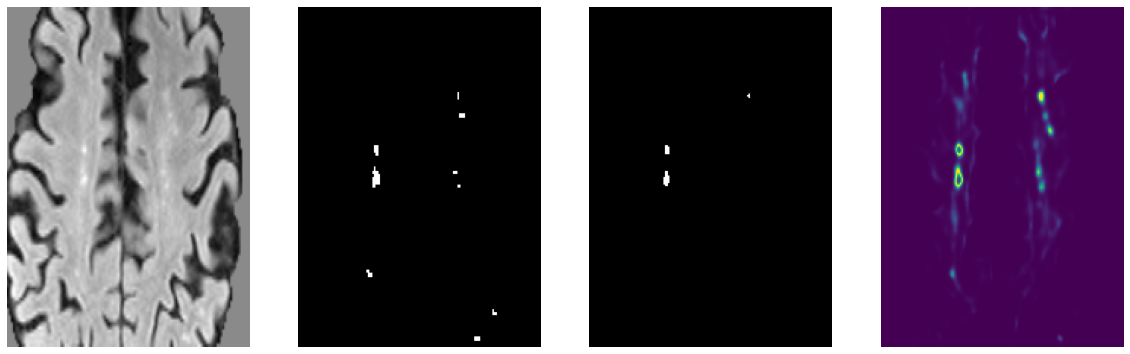

In [85]:
ind = 50
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

In [102]:
with torch.no_grad():
    steps = 5
    device = wrapped_interact_model.device
    new_result, update_maps, means = wrapped_interact_model(x1.to(device), y1.to(device), steps-1, diagnostic=True)

In [103]:
samples1 = fixed_re_parametrization_trick(new_result['distribution'], 20)
probs1 = torch.nn.functional.softmax(samples1, dim=2)
pic1 = torch.mean(probs1, dim=0)
ent_map1 = torch.sum(-pic1 * torch.log(pic1+1e-30), dim=1).cpu()

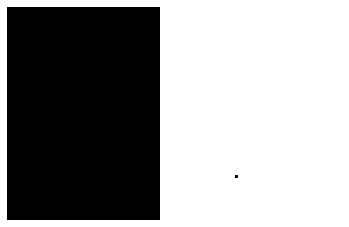

In [104]:
plt.subplot(1,2,1)
plt.imshow(update_maps[0][ind][0], cmap='gray'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(update_maps[0][ind][1], cmap='binary'); plt.axis('off');

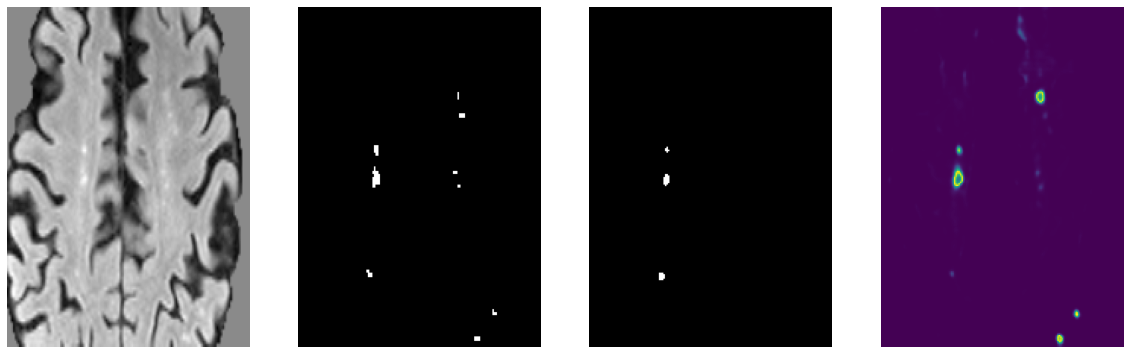

In [114]:
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(means[0].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map1[ind]); plt.axis('off')
#print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

tensor(0.5152)


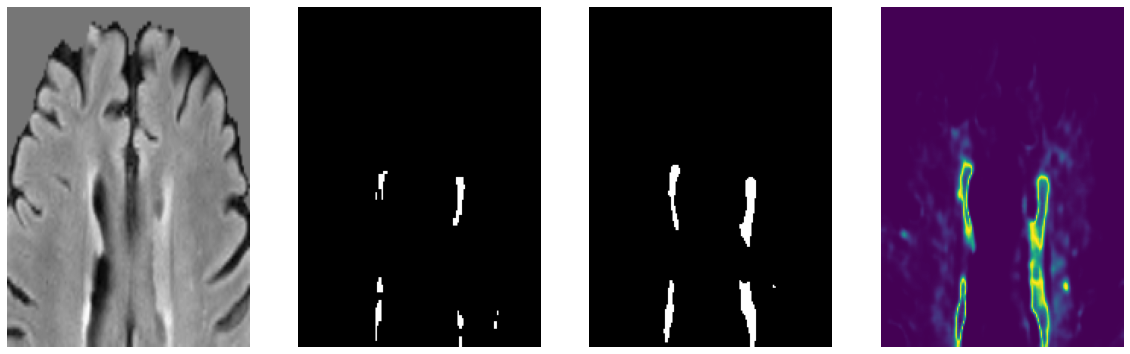

In [68]:
ind = 16#16 #27
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)[ind], cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(ent_map[ind]); plt.axis('off')
print(slice_dice(y_hat['logit_mean'].cpu()[ind], y1[ind]))
plt.show()

### Building the interactive model


### TODO
- need to filter out slices where the prediction exactly matches the target I guess.
- note that the distribution of true positive and false positive is not balanced at all so may need to do some clever sampling here.
- reweight new predictions in the training data. Need a mechanism for doing this, say once an epoch (im not sure it should be reweighted though actually, because otherwise it will just converge to the new stuff later on, so randomly sample from the whole lot actually is my view. Nice.
- extra augmentations impelment to prevent overfitting on the small validation data
- custom fitter code to run all of this.

In [78]:
y_pred = torch.nn.functional.softmax(y_hat['logit_mean'].cpu(), dim=1).argmax(dim=1)

In [328]:
ind = 17
y_pred_slice = y_pred[ind]
y1_slice = y1[ind]
diff = y_pred_slice != y1_slice
where = torch.where(diff)

update_point = torch.randint(0, len(where[0]), (1,)).item()

In [398]:
umap = generate_update_filter(y_pred_slice, y1_slice, 3)

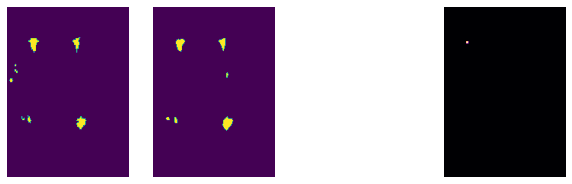

In [399]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(y1[ind]); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y_pred[ind]);plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(umap[0], cmap='binary'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(umap[1], cmap='magma'); plt.axis('off');